# Introduction
-  In this notebook, we will create a machine learning model to predict non-alcohol fatty liver disease.

The dataset contains the data from a population study of non-alcoholic fatty liver disease (NAFLD). Subjects with the condition and a set of matched control subjects were followed forward for metabolic conditions, cardiac endpoints, and death. This dataset is a data frame with 17549 observations on the following 10 variables:
  - id: subject identifier.
  - age: age at entry to the study.
  - male:  0=female, 1=male.
  - weight: weight in kg.
  - height: height in cm.
  - bmi: body mass index.
  - case.id: the id of the NAFLD case to whom this subject is matched.
  - futime: time to death or last follow-up.
  - status: 0= alive at last follow-up, 1=dead.

Details:
- The primary reference for the NAFLD study is Allen (2018). The incidence of non-alcoholic fatty liver disease (NAFLD) has been rising rapidly in the last decade and it is now one of the main drivers of hepatology practice Tapper2018. It is essentially the presence of excess fat in the liver, and parallels the ongoing obesity epidemic. Approximately 20-25% of NAFLD patients will develop the inflammatory state of non-alcoholic steatohepatitis (NASH), leading to fibrosis and eventual end-stage liver disease. NAFLD can be accurately diagnosed by MRI methods, but NASH diagnosis currently requires a biopsy.

- The current study constructed a population cohort of all adult NAFLD subjects from 1997 to 2014 along with 4 potential controls for each case. To protect patient confidentiality all time intervals are in days since the index date; none of the dates from the original data were retained. Subject age is their integer age at the index date, and the subject identifier is an arbitrary integer. As a final protection, we include only a 90% random sample of the data. As a consequence analyses results will not exactly match the original paper.

#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#Read dataset

In [2]:
data = pd.read_csv("/content/nafld1.csv")
data.head()

,Unnamed: 0,id,age,male,weight,height,bmi,case.id,futime,status
0,3631,1,57,0,60.0,163.0,22.690939,10630.0,6261,0
1,8458,2,67,0,70.4,168.0,24.884028,14817.0,624,0
2,6298,3,53,1,105.8,186.0,30.453537,3.0,1783,0
3,15398,4,56,1,109.3,170.0,37.830100,6628.0,3143,0
4,13261,5,68,1,NaN,NaN,NaN,1871.0,1836,1


#Visualizing Dataset Makeup


<Axes: xlabel='male', ylabel='count'>

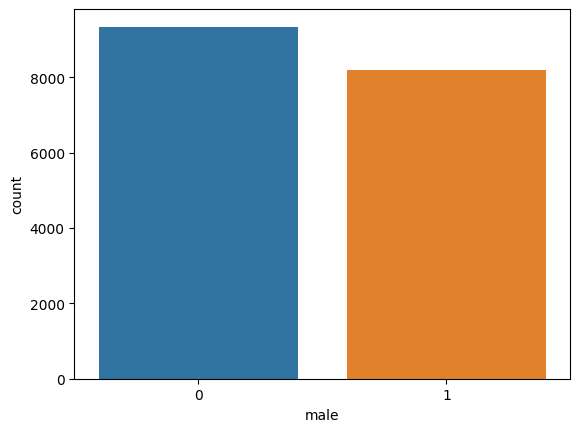

In [3]:
sns.countplot(x ='male', data = data)

<Axes: xlabel='age', ylabel='Density'>

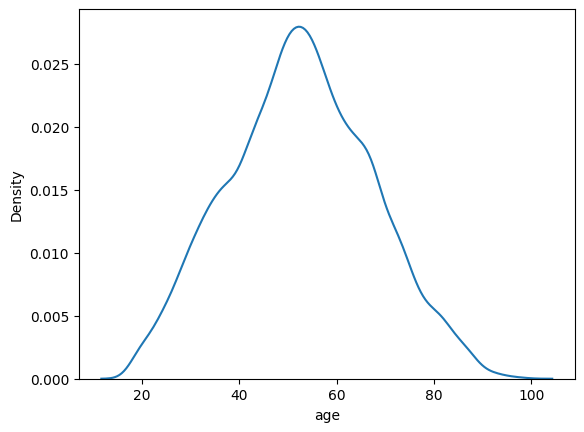

In [4]:
sns.kdeplot(data=data, x="age")

<Axes: xlabel='weight', ylabel='Density'>

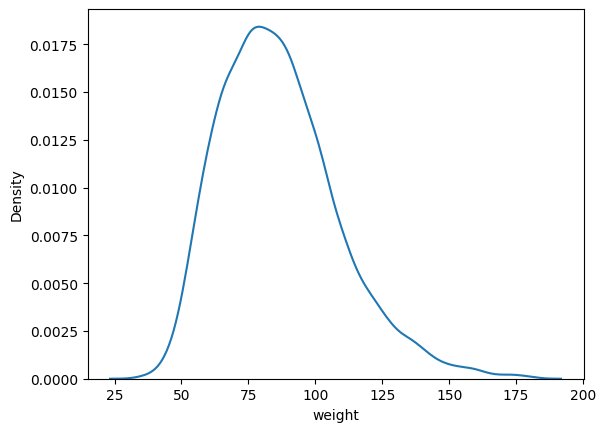

In [5]:
sns.kdeplot(data=data, x="weight")

<Axes: xlabel='height', ylabel='Density'>

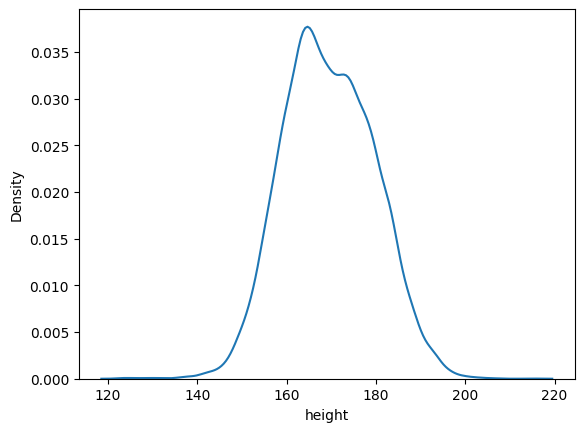

In [6]:
sns.kdeplot(data=data, x="height")

<Axes: xlabel='bmi', ylabel='Density'>

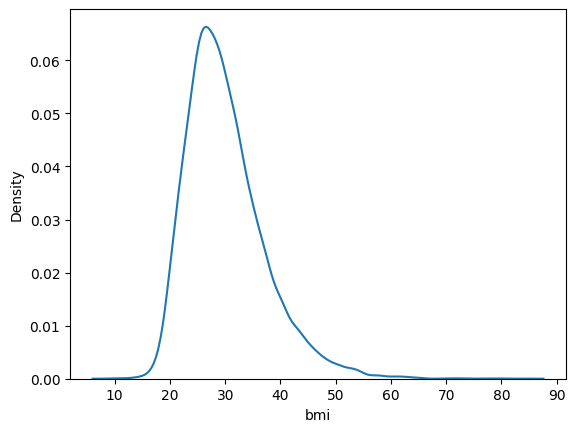

In [7]:
sns.kdeplot(data=data, x="bmi")

<Axes: xlabel='futime', ylabel='Density'>

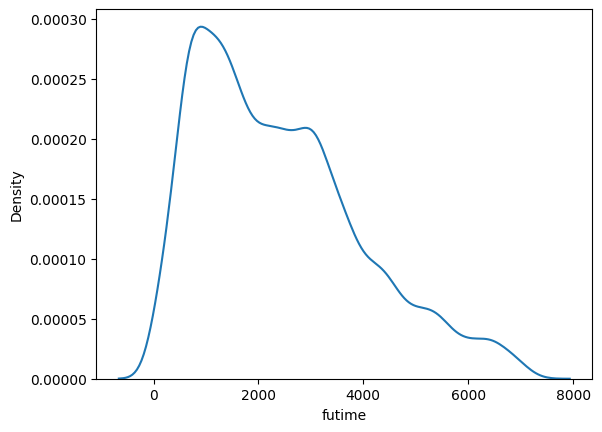

In [8]:
sns.kdeplot(data=data, x="futime")

Label data imbalance

<Axes: xlabel='status', ylabel='count'>

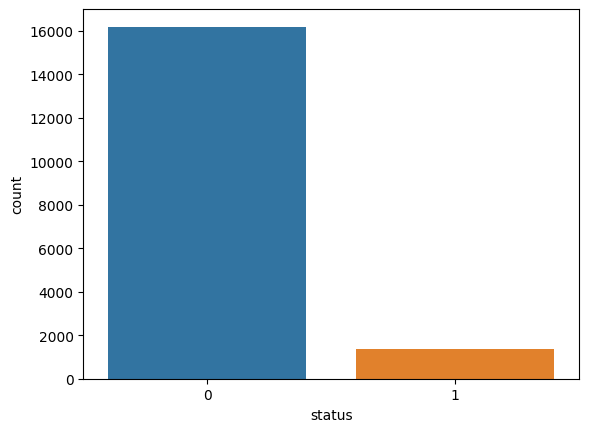

In [9]:
sns.countplot(x ='status', data = data)

#Visualizing Correlations With Label

<Axes: xlabel='male', ylabel='count'>

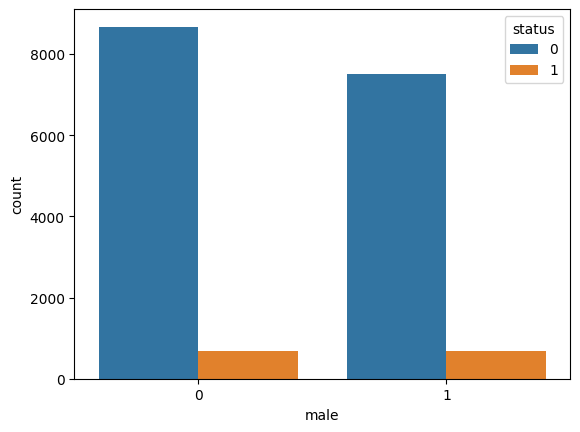

In [10]:
sns.countplot(data=data, x="male", hue="status")

<Axes: xlabel='age', ylabel='Density'>

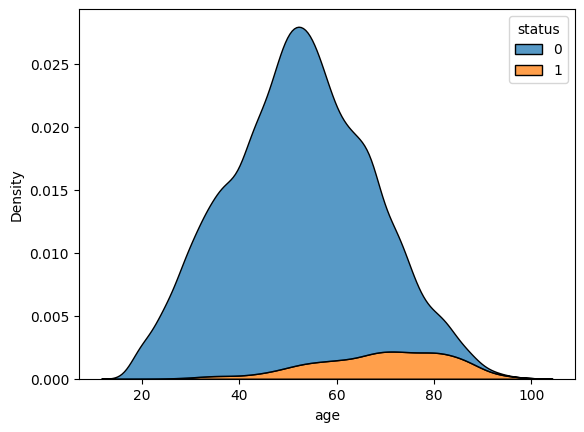

In [11]:
sns.kdeplot(data=data, x="age", hue="status", multiple="stack")

<Axes: xlabel='weight', ylabel='Density'>

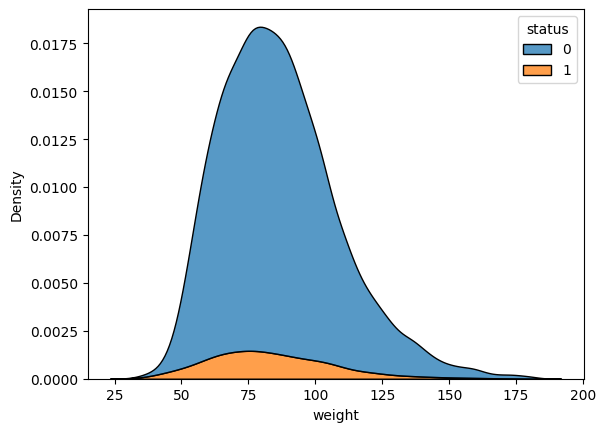

In [12]:
sns.kdeplot(data=data, x="weight", hue="status", multiple="stack")

<Axes: xlabel='height', ylabel='Density'>

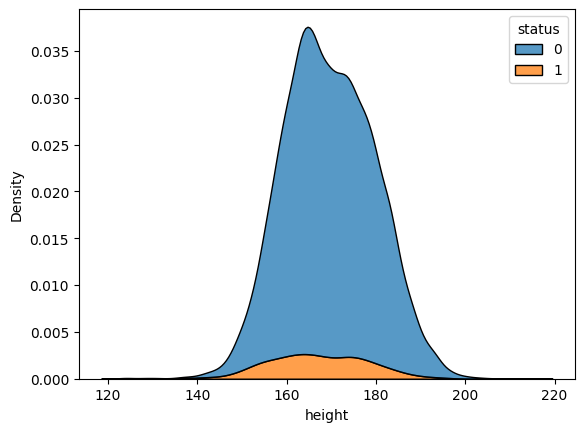

In [13]:
sns.kdeplot(data=data, x="height", hue="status", multiple="stack")

<Axes: xlabel='bmi', ylabel='Density'>

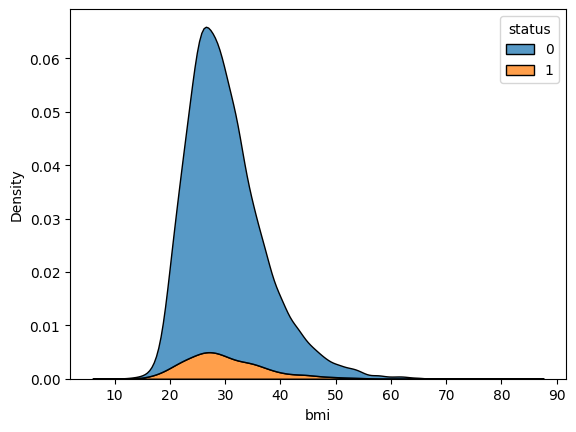

In [14]:
sns.kdeplot(data=data, x="bmi", hue="status", multiple="stack")

<Axes: xlabel='futime', ylabel='Density'>

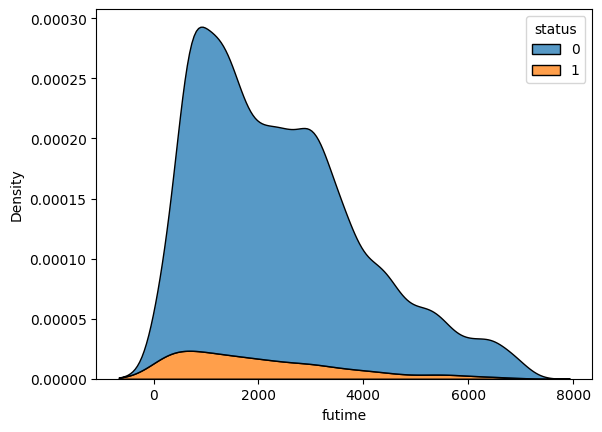

In [15]:
sns.kdeplot(data=data, x="futime", hue="status", multiple="stack")

#Overview dataset

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17549 entries, 0 to 17548
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  17549 non-null  int64  
 1   id          17549 non-null  int64  
 2   age         17549 non-null  int64  
 3   male        17549 non-null  int64  
 4   weight      12763 non-null  float64
 5   height      14381 non-null  float64
 6   bmi         12588 non-null  float64
 7   case.id     17518 non-null  float64
 8   futime      17549 non-null  int64  
 9   status      17549 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 1.3 MB


In [17]:
data.describe()

,Unnamed: 0,id,age,male,weight,height,bmi,case.id,futime,status
count,17549.000000,17549.000000,17549.000000,17549.000000,12763.000000,14381.000000,12588.000000,17518.000000,17549.000000,17549.000000
mean,8780.106046,8784.215967,52.659639,0.467320,86.353350,169.434949,30.073865,8840.924478,2410.600547,0.077725
std,5070.539328,5070.970712,14.722515,0.498945,22.239458,10.141421,7.085435,5051.334075,1573.017638,0.267746
min,1.000000,1.000000,18.000000,0.000000,33.400000,123.000000,9.207332,3.000000,7.000000,0.000000
25%,4389.000000,4393.000000,42.000000,0.000000,70.000000,162.000000,25.136434,4598.000000,1132.000000,0.000000
50%,8778.000000,8786.000000,53.000000,0.000000,83.900000,169.000000,28.875884,8781.000000,2148.000000,0.000000
75%,13171.000000,13175.000000,63.000000,1.000000,99.200000,177.000000,33.710372,13249.000000,3353.000000,0.000000
max,17566.000000,17566.000000,98.000000,1.000000,181.700000,215.000000,84.395725,17563.000000,7268.000000,1.000000


In [18]:
print("\tTHE NUMBER OF UNIQUE VALUES BY COLUMNS:")
data.nunique()

	THE NUMBER OF UNIQUE VALUES BY COLUMNS:


Unnamed: 0    17549
id            17549
age              81
male              2
weight         1145
height           80
bmi           11958
case.id        3853
futime         5536
status            2
dtype: int64

It can be seen that the number of Nans in this dataset is quite large.

In [19]:
print("Number of NaN values:\t", data.isna().sum().sum())

Number of NaN values:	 12946


In [20]:
data.age.value_counts()

50    527
54    507
52    500
55    496
53    491
     ... 
94      6
96      3
98      3
95      2
97      2
Name: age, Length: 81, dtype: int64

In [21]:
data.male.value_counts()

0    9348
1    8201
Name: male, dtype: int64

In [22]:
data.weight.value_counts()

73.2     54
90.9     52
93.2     52
82.3     50
69.1     46
         ..
43.3      1
161.0     1
138.1     1
163.1     1
131.4     1
Name: weight, Length: 1145, dtype: int64

In [23]:
data.height.value_counts()

163.0    663
165.0    585
166.0    563
170.0    545
168.0    537
        ... 
124.0      1
207.0      1
132.0      1
128.0      1
127.0      1
Name: height, Length: 80, dtype: int64

In [24]:
data.bmi.value_counts()

30.186697    5
27.047114    4
24.506271    4
25.910078    4
26.218043    4
            ..
33.479240    1
24.442163    1
20.625541    1
33.402025    1
29.204650    1
Name: bmi, Length: 11958, dtype: int64

In [25]:
data.futime.value_counts()

622     14
1490    14
628     14
2085    13
560     13
        ..
5554     1
5995     1
6945     1
4186     1
1124     1
Name: futime, Length: 5536, dtype: int64

In [26]:
perc=[]
for col in list(data.columns):
   perc.append(round(len(data[(data[col].isna())])/len(data)*100,2))

In [27]:
((pd.DataFrame([data.columns, perc]).T).rename(columns={0: "Feature", 1: "Percentage"})).sort_values(by="Percentage", ascending=False)

,Feature,Percentage
6,bmi,28.27
4,weight,27.27
5,height,18.05
7,case.id,0.18
0,Unnamed: 0,0.0
1,id,0.0
2,age,0.0
3,male,0.0
8,futime,0.0
9,status,0.0


#Preprocessing Data

In [28]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = pd.read_csv("/content/nafld1.csv")
data.head()

,Unnamed: 0,id,age,male,weight,height,bmi,case.id,futime,status
0,3631,1,57,0,60.0,163.0,22.690939,10630.0,6261,0
1,8458,2,67,0,70.4,168.0,24.884028,14817.0,624,0
2,6298,3,53,1,105.8,186.0,30.453537,3.0,1783,0
3,15398,4,56,1,109.3,170.0,37.830100,6628.0,3143,0
4,13261,5,68,1,NaN,NaN,NaN,1871.0,1836,1


In [29]:
def countna(df, column):
    col = pd.Series(list(df.loc[:,column]))
    num = col.isna().sum()
    print(column, " has", num, "na values")
for column in data.columns: countna(data, column)

Unnamed: 0  has 0 na values
id  has 0 na values
age  has 0 na values
male  has 0 na values
weight  has 4786 na values
height  has 3168 na values
bmi  has 4961 na values
case.id  has 31 na values
futime  has 0 na values
status  has 0 na values


Extract features for training and labels:
- In this dataset, we only use ['age','male','weight','height','bmi','futime'] as training data.
- Using the "status' column as label data.

In [30]:
data = data.drop(['id', 'Unnamed: 0', 'case.id'], axis=1)

alldata = data.copy()
y = data.pop('status')

In [31]:
data.head()

,age,male,weight,height,bmi,futime
0,57,0,60.0,163.0,22.690939,6261
1,67,0,70.4,168.0,24.884028,624
2,53,1,105.8,186.0,30.453537,1783
3,56,1,109.3,170.0,37.830100,3143
4,68,1,NaN,NaN,NaN,1836


Handling NaN data in a dataset
- To handle missing values (NaN) in a dataset, one approach is to utilize the KNNImputer library from scikit-learn.
- The KNNImputer library is designed to impute missing values in observations by identifying the nearest neighbors based on the Euclidean distance matrix. It fills in the missing values by considering the values of the nearest neighbors.
- Using KNNImputer can be beneficial in cases where missing values are randomly distributed across the dataset. By leveraging the relationships between the existing data points, KNNImputer estimates and replaces the missing values with values that are considered similar based on the neighboring observations.
- By employing the KNNImputer library, we can effectively handle NaN values in a dataset and ensure that the missing data is appropriately imputed for subsequent analysis or modeling tasks.

In [32]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer = imputer.fit(data)
data = imputer.transform(data)

The reason for addressing imbalanced datasets is to prevent the model from exhibiting bias towards the majority class, which typically has a larger number of samples.

There are various approaches to handling imbalanced data, for example:
+ Adding more data: Increasing the number of samples in the minority class can help improve its representation in the dataset.
+ Changing performance metrics: Instead of relying solely on accuracy, using alternative metrics such as precision, recall, or F1 score can provide a more comprehensive evaluation of the model's performance.
+ Penalized models: Applying penalties to the algorithm during training to prioritize the minority class can help mitigate the imbalance.
+ Changing algorithms: Exploring different algorithms that are more robust to imbalanced data, such as ensemble methods or gradient boosting, can yield better results.
+ Resampling: This technique involves either undersampling the majority class or oversampling the minority class to create a more balanced dataset. Undersampling reduces the number of observations from the majority class, while oversampling replicates or synthesizes new instances for the minority class.

In this particular case, we have chosen to use undersampling.
- Undersampling involves reducing the number of instances in the majority class to match the number of instances in the minority class. This approach quickly balances the dataset without requiring complex sampling algorithms. However, a drawback is that the sample size will be significantly reduced.
- The reason for selecting undersampling in this scenario is due to the sensitive nature of the medical field. It is crucial to have accurate and reliable data for making correct predictions about a patient's condition. Oversampling can introduce artificial data, which may raise ethical concerns and compromise accuracy. Therefore, undersampling is considered a more appropriate method, even though it may result in the loss of some important information.

In [33]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = rus.fit_resample(data, y)

Text(0.5, 1.0, 'Status After Resampling')

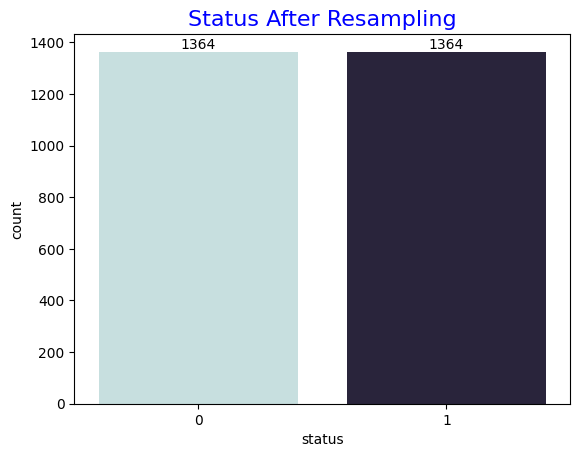

In [34]:
ax = sns.countplot(x=y_resampled,palette='ch:start=.2,rot=-.3')
plt.bar_label(ax.containers[0])
plt.title("Status After Resampling", fontsize=16, color='b')

Train Test Split

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2,random_state=42)

Data normalization is a technique utilized to standardize input data, aiming to prevent certain columns with larger values from exerting a disproportionate influence on the model's predictions while potentially overlooking columns with smaller values.

There are two widely employed methods for data normalization:
  + Min-Max normalization: This technique scales the values of a feature to a range between 0 and 1. This is done by subtracting the minimum value of the feature from each value, and then dividing by the range of the feature.
  + Data standardization: also known as feature scaling, is a technique in machine learning that transforms numerical features to have a mean of 0 and a standard deviation of 1. It ensures that features are on a common scale and prevents bias based on magnitude. Standardization facilitates gradient descent optimization, aids interpretability of coefficients, and should be applied consistently to training and test data.

-> In the context of this dataset, the chosen approach is Min-Max normalization, specifically utilizing the Min-Max normalization method. The objective is to ensure that all the training data in each column is transformed to fall within the range of [0, 1]. This normalization procedure helps mitigate any potential bias arising from columns with larger values, enabling all columns to contribute equally to the model's predictions.

In [36]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(x_train)

# transform training data
x_train = norm.transform(x_train)
X_resampled = norm.transform(x_resampled)
# transform testing data
x_test = norm.transform(x_test)

#Visualizing Class Correlation

In [37]:
pre_data = pd.DataFrame(x_resampled, columns = ['age','male','weight','height','bmi','futime'])
pre_data.head()

,age,male,weight,height,bmi,futime
0,41.0,1.0,87.8,170.5,29.841404,729.0
1,41.0,1.0,77.9,180.5,23.832105,6805.0
2,38.0,1.0,111.2,186.0,32.326520,1816.0
3,46.0,0.0,62.7,174.0,20.789078,2834.0
4,50.0,0.0,63.4,159.0,25.219999,3344.0


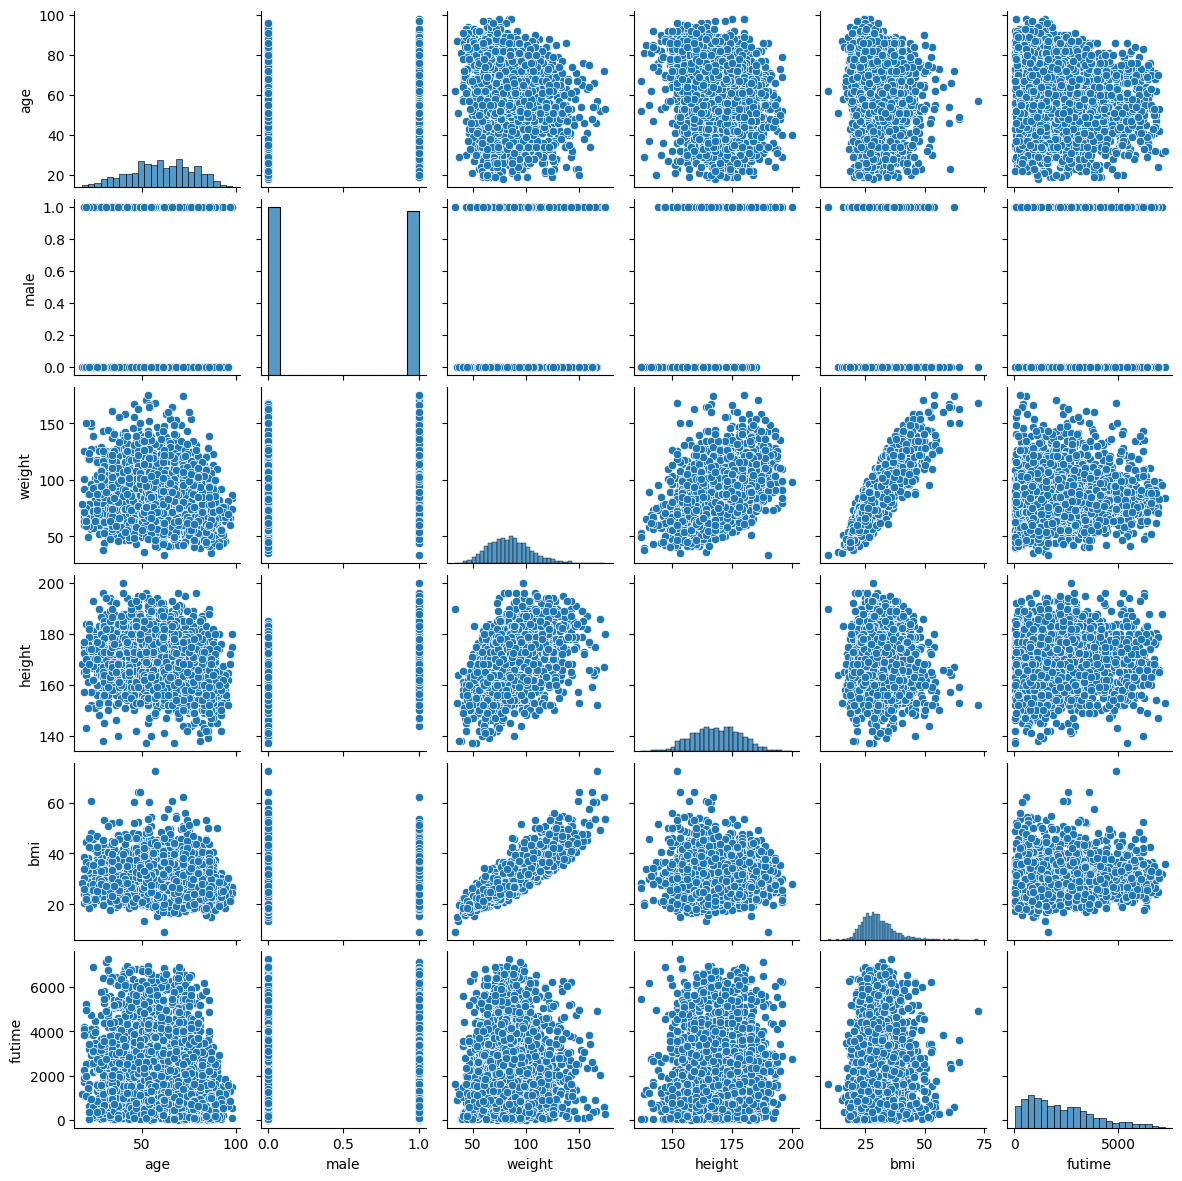

In [38]:
sns.pairplot(data = pre_data, height = 2)

#Model

We have chosen two models, Decision Tree and KNN (K-Nearest Neighbors), for the following reasons:

- When observing the dataset, we noticed a correlation between the input data and the labels. Therefore, we selected the Decision Tree model, as it is known for its ability to capture and utilize such relationships in the data.
- We chose KNN because it is a lazy learning model, meaning it relies on the distances between neighbors to make predictions. We believe that this approach could be beneficial in our case, as it can potentially capture local patterns and similarities within the data.

The suitability and effectiveness of Decision Tree and KNN models should be evaluated through experimentation and comparison to find which is a better model.Additionally, we mentioned our interest in understanding whether a lazy model can outperform a learning model.

##Decision Tree

###Train model

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

dt=DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       290
           1       0.64      0.69      0.66       256

    accuracy                           0.67       546
   macro avg       0.67      0.67      0.67       546
weighted avg       0.67      0.67      0.67       546



Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

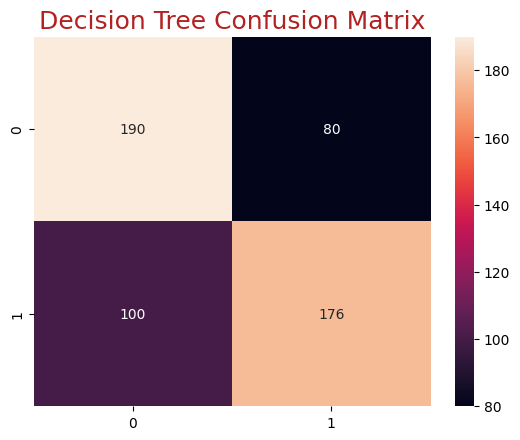

In [40]:
sns.heatmap(confusion_matrix(y_test, dt.predict(x_test)), annot=True, fmt='.0f')
plt.title("Decision Tree Confusion Matrix", fontsize=18, color='firebrick')

### K Fold Cross Validation

In [41]:
scoring = ['accuracy','precision','recall','f1']
score=cross_validate(estimator=DecisionTreeClassifier(),X=X_resampled,y=y_resampled,cv=5,scoring=scoring)
score = list(score.values())[2:]

In [42]:
acc_dt_before = np.mean(score[0])
pres_dt_before = np.mean(score[1])
recall_dt_before = np.mean(score[2])
f1_dt_before = np.mean(score[3])


In [43]:
print("Average accuracy: ", np.mean(acc_dt_before))
print("Average precision: ", np.mean(pres_dt_before))
print("Average recall: ", np.mean(recall_dt_before))
print("Average F1: ", np.mean(f1_dt_before))

Average accuracy:  0.6748583526565177
Average precision:  0.6767170703037362
Average recall:  0.6723120017237665
Average F1:  0.6740803011187088


### Grid Search Cross Validation

In [44]:
parameters = {'max_depth':np.arange(3,20),
              'min_samples_split': np.arange(3,20),
              'min_samples_leaf':np.arange(3,20),
              'max_leaf_nodes' : [4,8, 16, 32],
              'criterion': ('gini', 'entropy')}


start_time = time.time()
tree_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=parameters, scoring='accuracy', n_jobs=-1, verbose=3)
tree_grid.fit(x_train, y_train)
done_time = time.time() - start_time

Fitting 5 folds for each of 39304 candidates, totalling 196520 fits


In [45]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",tree_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",tree_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",tree_grid.best_params_)
print('\nExecution time: {:.4f}s'.format(done_time))

 Results from Grid Search 

 The best estimator across ALL searched params:
 DecisionTreeClassifier(max_depth=5, max_leaf_nodes=8, min_samples_leaf=14,
                       min_samples_split=3)

 The best score across ALL searched params:
 0.752518212163836

 The best parameters across ALL searched params:
 {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 8, 'min_samples_leaf': 14, 'min_samples_split': 3}

Execution time: 881.5312s


In [46]:
y_pred = tree_grid.predict(x_test)

acc_dt_after = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy: ", acc_dt_after)
pres_dt_after = precision_score(y_test, y_pred)
print("Decision Tree Precision: ", pres_dt_after)
recall_dt_after = recall_score(y_test, y_pred)
print("Decision Tree Recall: ", recall_dt_after)
f1_dt_after = f1_score(y_test, y_pred)
print("Decision Tree F1: ", f1_dt_after)
print('\n', classification_report(y_pred, y_test))

Decision Tree Accuracy:  0.7417582417582418
Decision Tree Precision:  0.8260869565217391
Decision Tree Recall:  0.6195652173913043
Decision Tree F1:  0.7080745341614906

               precision    recall  f1-score   support

           0       0.87      0.69      0.77       339
           1       0.62      0.83      0.71       207

    accuracy                           0.74       546
   macro avg       0.74      0.76      0.74       546
weighted avg       0.77      0.74      0.75       546



Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

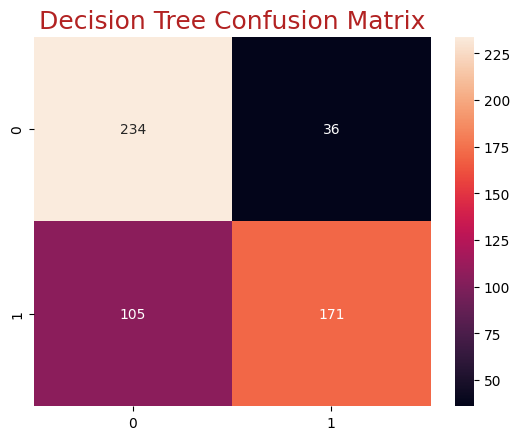

In [47]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
plt.title("Decision Tree Confusion Matrix", fontsize=18, color='firebrick')

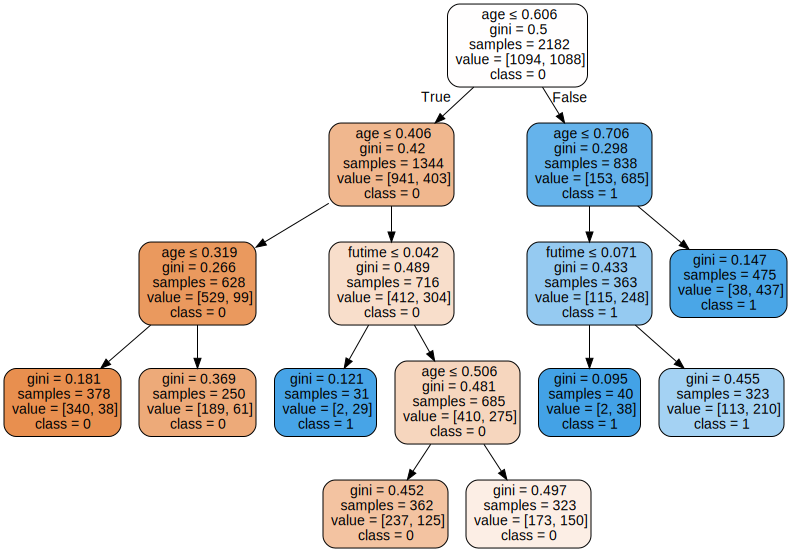

In [48]:
dt=DecisionTreeClassifier(criterion= 'gini', max_depth= 5, min_samples_leaf= 14, min_samples_split= 3,max_leaf_nodes=8)
dt.fit(x_train,y_train)

feature_names = ['age','male','weight','height','bmi','futime']
dot_data = tree.export_graphviz(dt, out_file=None, max_depth=6, feature_names=feature_names, class_names=['0', '1'], filled=True, rounded=True, special_characters=True)
graphviz.Source(dot_data)

##K-NN

###Train model

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       308
           1       0.65      0.75      0.70       238

    accuracy                           0.71       546
   macro avg       0.72      0.72      0.71       546
weighted avg       0.72      0.71      0.72       546



Text(0.5, 1.0, 'K-NN Confusion Matrix')

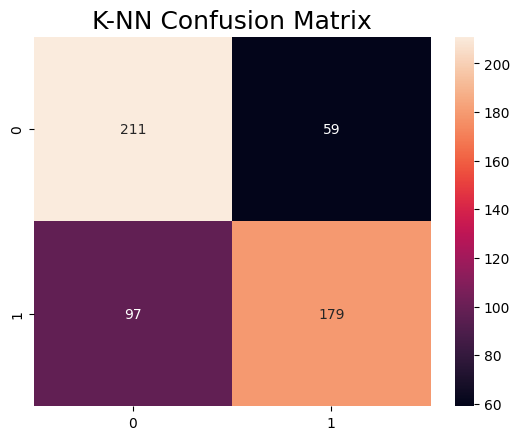

In [50]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
plt.title("K-NN Confusion Matrix", fontsize=18)

###K Fold Cross Validation

In [51]:
scoring = ['accuracy','precision','recall','f1']
score=cross_validate(estimator=KNeighborsClassifier(n_neighbors=5),X=X_resampled,y=y_resampled,cv=5,scoring=scoring)
score = list(score.values())[2:]

In [52]:
acc_knn_before = np.mean(score[0])
pres_knn_before = np.mean(score[1])
recall_knn_before = np.mean(score[2])
f1_knn_before = np.mean(score[3])

In [53]:
print("Average accuracy: ", np.mean(acc_knn_before))
print("Average precision: ", np.mean(pres_knn_before))
print("Average recall: ", np.mean(recall_knn_before))
print("Average F1: ", np.mean(f1_knn_before))

Average accuracy:  0.7199341331451424
Average precision:  0.7331823061448872
Average recall:  0.6913757810816634
Average F1:  0.7114394863256226


### Grid Search Cross Validation

In [54]:
k_range = [i for i in range(1, 100,2)]
weight_options = ['uniform', 'distance']
distance_metric = ['euclidean', 'manhattan']
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=distance_metric)
print(param_grid)

{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}


In [55]:
start_time = time.time()
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', return_train_score=False)
knn_grid.fit(x_train, y_train)
done_time = time.time() - start_time

In [56]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",knn_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",knn_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",knn_grid.best_params_)
print('\nExecution time: {:.4f}s'.format(done_time))

 Results from Grid Search 

 The best estimator across ALL searched params:
 KNeighborsClassifier(metric='manhattan', n_neighbors=99, weights='distance')

 The best score across ALL searched params:
 0.7520773413389876

 The best parameters across ALL searched params:
 {'metric': 'manhattan', 'n_neighbors': 99, 'weights': 'distance'}

Execution time: 17.6078s


In [57]:
y_pred = knn_grid.predict(x_test)

acc_knn_after = accuracy_score(y_test, y_pred)
print("K-NN Accuracy: ", acc_knn_after)
pres_knn_after = precision_score(y_test, y_pred)
print("K-NN Precision: ", pres_knn_after)
recall_knn_after = recall_score(y_test, y_pred)
print("K-NN Recall: ", recall_knn_after)
f1_knn_after = f1_score(y_test, y_pred)
print("K-NN F1: ", f1_knn_after)
print('\n', classification_report(y_test, y_pred))

K-NN Accuracy:  0.7362637362637363
K-NN Precision:  0.782051282051282
K-NN Recall:  0.6630434782608695
K-NN F1:  0.7176470588235294

               precision    recall  f1-score   support

           0       0.70      0.81      0.75       270
           1       0.78      0.66      0.72       276

    accuracy                           0.74       546
   macro avg       0.74      0.74      0.74       546
weighted avg       0.74      0.74      0.73       546



Text(0.5, 1.0, 'K-NN Confusion Matrix')

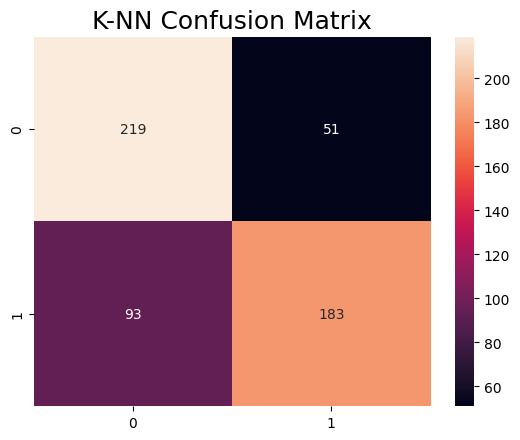

In [58]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
plt.title("K-NN Confusion Matrix", fontsize=18)

# Visualize Comparision

## Compare before and after tuning parameters

In [59]:
score = ['Accuracy', 'Precision', 'Recall', 'F1']
Decision_Tree_before = [acc_dt_before, pres_dt_before, recall_dt_before, f1_dt_before]
Decision_Tree_after = [acc_dt_after, pres_dt_after, recall_dt_after, f1_dt_after]
KNN_before = [acc_knn_before, pres_knn_before, recall_knn_before, f1_knn_before]
KNN_after = [acc_knn_after, pres_knn_after, recall_knn_after, f1_knn_after]

blogs = pd.DataFrame({'score': score, 'Decision_Tree_before': Decision_Tree_before,
                      'Decision_Tree_after': Decision_Tree_after, 'KNN_before': KNN_before, 'KNN_after': KNN_after})


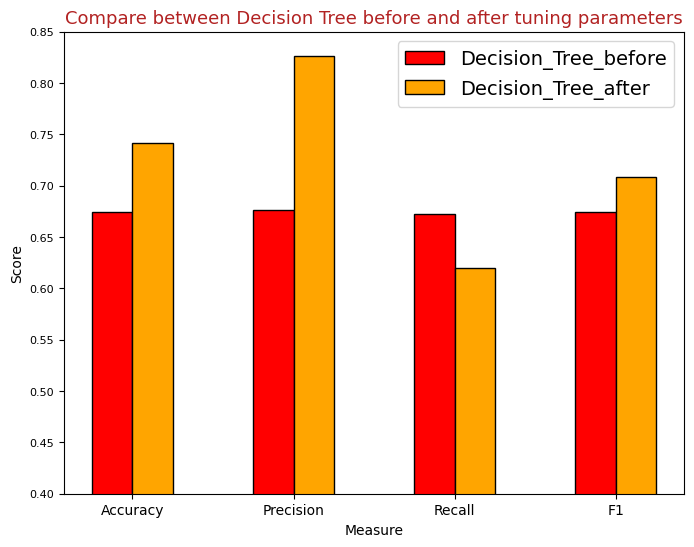

In [104]:
# Visualizing the data with multiple bar chart
plt.figure(figsize=[8, 6])

# Set the width of the bars
wd = 0.5
x_pos = np.arange(1, 2*len(blogs), 2)

# Plotting the multiple bar graphs on the same figure
plt.bar(x_pos, blogs.Decision_Tree_before, color='r', width=wd, edgecolor='k',
        label='Decision_Tree_before')
plt.bar(x_pos+wd, blogs.Decision_Tree_after, color='orange', width=wd, edgecolor='k',
        label='Decision_Tree_after')

# Add xticks
plt.xticks(x_pos+(wd*0.5), blogs.score.values, fontsize=10)
plt.yticks(fontsize=8)
plt.title('Compare between Decision Tree before and after tuning parameters', fontsize=13, color='firebrick')
plt.xlabel('Measure', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.ylim(0.4,0.85)
plt.legend(loc='best', fontsize=14)
plt.show()

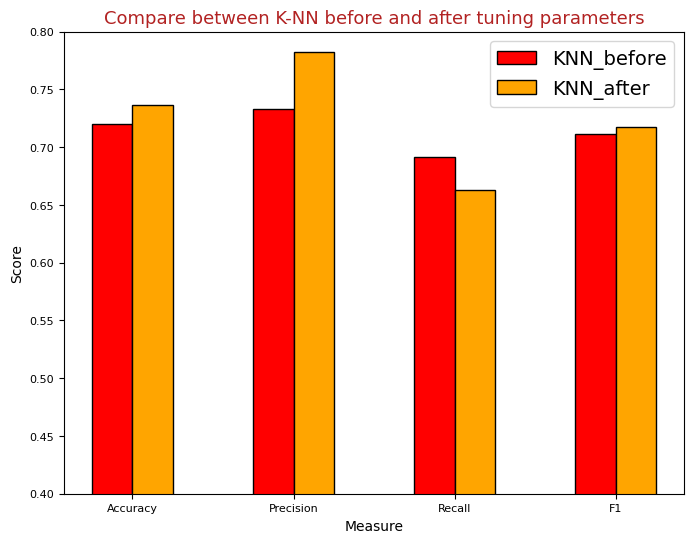

In [103]:
# Visualizing the data with multiple bar chart
plt.figure(figsize=[8, 6])

# Set the width of the bars
wd = 0.5
x_pos = np.arange(1, 2*len(blogs), 2)

# Plotting the multiple bar graphs on the same figure
plt.bar(x_pos, blogs.KNN_before, color='red', width=wd, edgecolor='k',
        label='KNN_before')
plt.bar(x_pos+wd, blogs.KNN_after, color='orange', width=wd, edgecolor='k',
        label='KNN_after')

# Add xticks
plt.xticks(x_pos+(wd*0.5), blogs.score.values, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Compare between K-NN before and after tuning parameters', fontsize=13, color='firebrick')
plt.xlabel('Measure', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.ylim(0.4,0.8)
plt.legend(loc='best', fontsize=14)
plt.show()

## Compare between methods

### Before tuning

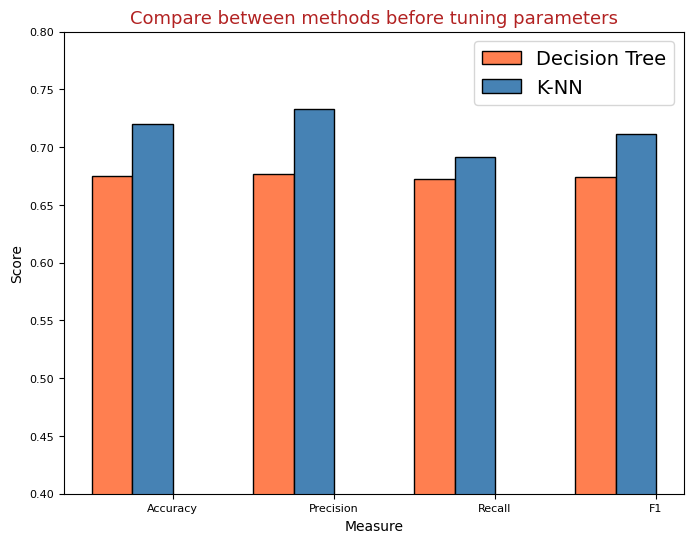

In [102]:
# Visualizing the data with multiple bar chart
plt.figure(figsize=[8, 6])

# Set the width of the bars
wd = 0.5
x_pos = np.arange(1, 2*len(blogs), 2)

# Plotting the multiple bar graphs on the same figure
plt.bar(x_pos, blogs.Decision_Tree_before, color='coral', width=wd, edgecolor='k',
        label='Decision Tree')
plt.bar(x_pos+(wd), blogs.KNN_before, color='steelblue', width=wd,
        edgecolor='k', label='K-NN')

# Add xticks
plt.xticks(x_pos+(wd*1.5), blogs.score.values, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Compare between methods before tuning parameters', fontsize=13, color='firebrick')
plt.xlabel('Measure', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.ylim(0.4,0.8)
plt.legend(loc='best', fontsize=14)
plt.show()

###After tuning

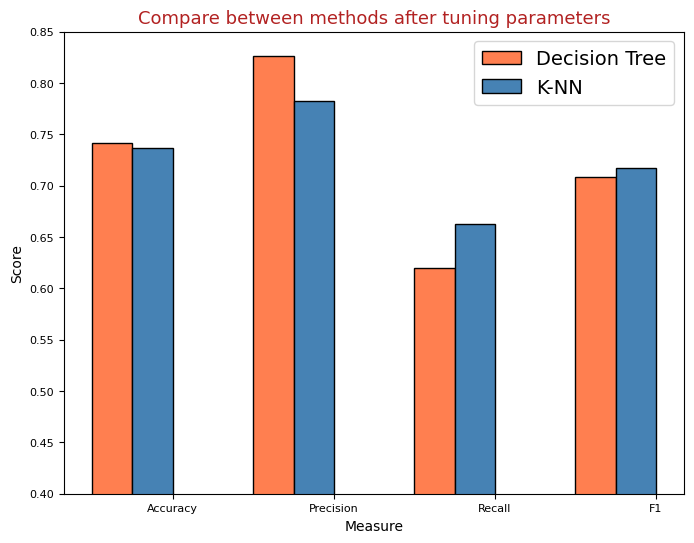

In [101]:
# Visualizing the data with multiple bar chart
plt.figure(figsize=[8, 6])

# Set the width of the bars
wd = 0.5
x_pos = np.arange(1, 2*len(blogs), 2)

# Plotting the multiple bar graphs on the same figure
plt.bar(x_pos, blogs.Decision_Tree_after, color='coral', width=wd, edgecolor='k',
        label='Decision Tree')
plt.bar(x_pos+(wd), blogs.KNN_after, color='steelblue', width=wd,
        edgecolor='k', label='K-NN')

# Add xticks
plt.xticks(x_pos+(wd*1.5), blogs.score.values, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Compare between methods after tuning parameters', fontsize=13, color='firebrick')
plt.xlabel('Measure', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.ylim(0.4,0.85)
plt.legend(loc='best', fontsize=14)
plt.show()